<h2>
An Analysis of <i>The Lazy Fundamental Analyst</i>
</h2>
<p>
The book <i>The Lazy Fundamental Analyst</i> by Fred Piard, 2014, proposes an investment strategy that utilizes fundamental factors
like Price Earnings (PE) and Return on Assets (ROA) to select stocks within a sector. This is combined with a market timing
signal based on S&P 500 earnings per share momentum and unemployment momentum.
</p>
<p>
This Jupyter notebook is opensource, published under the Apache II license. The notebook can be found on
GitHub: <a href="https://github.com/IanLKaplan/lazy_fundamental_analyst">https://github.com/IanLKaplan/lazy_fundamental_analyst</a>
</p>
<p>
Fred Paird's book states that it is written for the average investor who is willing to spend a limited amount of time
each month on their investments. Considering the data issues, especially in regard to the data needed to
construct the unemployment momentum signal, the time dedicated to investment may be underestimated.
</p>
<p>
This notebook attempts to verify some of the results reported in the book. In the print edition of the book the plots are
difficult to read. The results that can be inferred from the plots and the text show that Piard's hedged portfolios perform
well, with lower risk and higher returns than the sector portfolios.
</p>
<p>
The results in this notebook suggest that the investment approach suggested by Fred Paird would, at best,
lead to portfolio performance significantly less than holding an S&P 500 ETF and, for the hedged portfolios, significant
losses.
</p>
<p>
A reader who does not have the skills to perform the type of analysis used in this notebook would be wise to invest in
a portfolio of index funds, rather than an investment scheme that they read about in a book. The alternative is to learn
through actual investment that the investment scheme did not work as well as described.
</p>
<h3>
Market Timing Signals
</h3>
<p>
The book provides fundamental factor models for stocks in the S&P 500 sectors. Each sector model also includes a
variation where the portfolio is hedged by a short position in the S&P 500 depending on the market timing signal
composed of the EPS estimate momentum and the unemployment momentum.
</p>
<p>
The market timing signals are fundamental macroeconomic indicators. The assumption is that when the signal is bearish
(there is declinging earnings per S&P 500 share or increasing unemployment) market prices will decline. There are a number
of factors that influence market prices, beyond these two factors. For example, at a time when interest rates are near zero,
there are fewer investment options, so the stock market may be overpriced in terms of fundamental indicators. This has caused
funamental investment funds to dramatically under-perform the market since 2010.
</p>
<p>
The results in this notebook are very different from the results reported in the book. In the book the hedged portfolios
(a short position in the S&P 500, perhaps via the SH ETF) all had significantly better performance than the unhedged
sector portfolios. The results in this notebook suggest that a market hedge, using the hedging signals described
by the author, would have significant losses because of a short S&P 500 postion during market rises.
</p>
<h4>
EPS Estimate Momentum
</h4>
<blockquote>
<p>
"EPS Estimate Momentum" is an aggregate fundamental ratio over the S&P 500 Index. It gives a bearish signal when
the S&P 500 current year EPS estimate is below its own value three months previously, and a bullish signal when it is
above this value.
</p>
<p>
<i>The Lazy Fundamental Analyst</i> by Fred Paird
</p>
</blockquote>
<h4>
Unemployment Momentum
</h4>
<blockquote>
<p>
It [Unemployment Momentum] gives a bearish signal when the US enemployment rate is above it's own value three months ago,
and a bullish signal when it is below this value. The US unemployment rate is published once a month, usually in the first half
of the month for the previous month.
</p>
</blockquote>
<p>
When one of the indicators is "bullish", the portfolio is invested in stocks. When the two indicators are "bearish" the
portfolio is hedged against the S&P 500 (via the ETF SH (ProShares 1x Short S&P 500)).
</p>
<h4>
Hedging the Portfolio
</h4>
<p>
In the book the author suggests that the stock portfolio should be hedged with both the EPS and Unemployment signals are
"bearish".
</p>
<h3>
EPS Estimate Momentum
</h3>
<p>
Monthly S&P 500 earnings yield, by month, is published on the NASDAQ data site, along with several other S&P 500 statistics. See
<a href="https://data.nasdaq.com/data/MULTPL-sp-500-ratios">S&P 500 Ratios</a>. The data can be retrieved from Python,
using the nasdaqdatalink package (see the import in the code below).
</p>
<p>
The NASDAQ datalink data can, in theory, be retreived using their anonymous API. This worked for me for a few days,
until it started to fail with a "too many data requests" error. To avoid this error, an API account must be registered.
The API account is free for personal and research use.
</p>
<p>
To sign up for an account see
<a href="https://data.nasdaq.com/sign-up">Nasdaq Data Link signup</a>. The NASDAQ
software will use an enviroment variable, NASDAQ_DATA_LINK_API_KEY, set to the key.
</p>
<p>
To set the NASDAQ_DATA_LINK_API_KEY environment variable include this in your setup file (e.g., .bashrc):
</p>
<p>
export NASDAQ_DATA_LINK_API_KEY=[your API key]
</p>
<p>
The data link documentation can be found on the
nasdaq <a href="https://github.com/Nasdaq/data-link-python">GitHub site for nasdaqdatalink</a>.
</p>
<p>
The Nasdaq data is for the monthly S&P 500 earnings yield. Fred Piard's EPS estimate momentum is the yearly sum, so
the estimate for 12 months is summed for the yearly value.
</p>

In [108]:
import os
from datetime import datetime, timedelta
from pathlib import Path
from typing import List, Callable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# https://data.nasdaq.com/tools/python
# pip install Nasdaq-Data-Link
import nasdaqdatalink as nasd
from pandas import DatetimeIndex

# pip install pandas-datareader
from pandas_datareader import data

import requests
import json
import jsonpickle as jp

import tempfile

plt.style.use('seaborn-whitegrid')

def convert_date(some_date):
    if type(some_date) == str:
        some_date = datetime.fromisoformat(some_date)
    elif type(some_date) == np.datetime64:
        ts = (some_date - np.datetime64('1970-01-01T00:00')) / np.timedelta64(1, 's')
        some_date = datetime.utcfromtimestamp(ts)
    return some_date


def findDateIndex(date_index: DatetimeIndex, search_date: datetime) -> int:
    '''
    In a DatetimeIndex, find the index of the date that is nearest to search_date.
    This date will either be equal to search_date or the next date that is less than
    search_date
    '''
    index: int = -1
    i = 0
    search_date = convert_date(search_date)
    date_t = datetime.today()
    for i in range(0, len(date_index)):
        date_t = convert_date(date_index[i])
        if date_t >= search_date:
            break
    if date_t > search_date:
        index = i - 1
    else:
        index = i
    return index


start_date_str = '2007-01-03'
start_date: datetime = datetime.fromisoformat(start_date_str)
# The "current date"
end_date: datetime = datetime.today() - timedelta(days=1)

class NASDQData:
    """
    eps_start_date: the data that the rolling 12-month sum should start at
    """

    def __init__(self, eps_start_date: datetime):
        self.start_date = eps_start_date
        self.S_AND_P_EARNINGS_KEY = "MULTPL/SP500_EARNINGS_YIELD_MONTH"
        self.DATALINK_KEY = 'NASDAQ_DATA_LINK_API_KEY'
        self.s_and_p_earnings_file = "s_and_p_earnings.csv"

    def get_s_and_p_earnings(self) -> pd.DataFrame:
        temp_root: str = tempfile.gettempdir() + '/'
        file_path: str = temp_root + self.s_and_p_earnings_file
        temp_file_path = Path(file_path)
        file_size = 0
        if temp_file_path.exists():
            file_size = temp_file_path.stat().st_size

        if file_size > 0:
            s_and_p_eps_yearly = pd.read_csv(file_path, index_col='Date')
        else:
            nasdaq_datalink_key = os.environ.get(self.DATALINK_KEY)
            if nasdaq_datalink_key == None:
                print("Warning: no NASDAQ data link key has been set in the environment")
            # For all of the S&P ratios see https://data.nasdaq.com/data/MULTPL-sp-500-ratios
            # https://data.nasdaq.com/data/MULTPL/SP500_EARNINGS_YIELD_MONTH-sp-500-earnings-yield-by-month
            try:
                back_start_date = self.start_date - timedelta(weeks=56)
                s_and_p_eps_raw = nasd.get("MULTPL/SP500_EARNINGS_YIELD_MONTH", start_date=back_start_date)
                eps_index = s_and_p_eps_raw.index
                ix_start = findDateIndex(eps_index, self.start_date - timedelta(weeks=52))
                assert ix_start >= 0
                s_and_p_eps = s_and_p_eps_raw[:][ix_start:]
                s_and_p_eps_yearly = s_and_p_eps.rolling(12).sum()
                ix_start = findDateIndex(eps_index, self.start_date)
                assert ix_start >= 0
                s_and_p_eps_yearly = round(s_and_p_eps_yearly[:][ix_start:], 2)
                s_and_p_eps_yearly.to_csv(file_path)
            except Exception as e:
                raise Exception(f'nasdaq-data-link error: {str(e)}')

        return s_and_p_eps_yearly


# The data returned will be the rolling yearly sum, so the start_date is backed up by a year to properly start
# on start-date.
nasdq_data = NASDQData(start_date)
eps_yearly = nasdq_data.get_s_and_p_earnings()

The yearly S&P 500 earnings per share (calculated by summing the rolling monthly earnings per share) is shown below

<AxesSubplot:title={'center':'Yearly S&P 500 Earnings yield'}, xlabel='Date'>

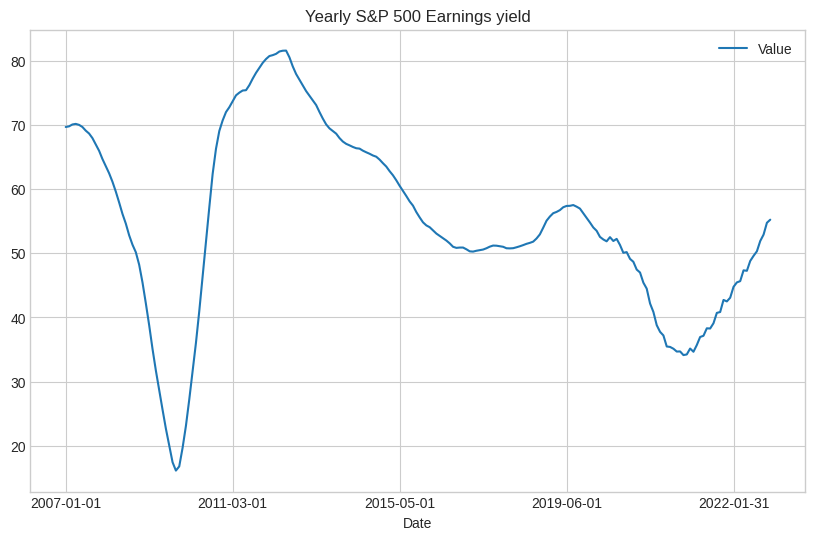

In [109]:

eps_yearly.plot(grid=True, title="Yearly S&P 500 Earnings yield", figsize=(10, 6))

<p>
The S&P 500 yearly earnings does look like it might be a credible market downturn signal.
</p>
<h3>
Unemployment Momentum
</h3>
<p>
Fred Piard writes that unemployment data "is widely broadcasted on fiancial and news websites". This is not much help for someone
who wants to perform quantitative analysis of the unemployment rate as a market signal.
</p>
<p>
United States unemployment rate statistics are published by the US Bureau of Labor Statistics. The data can be downloaded
via a REST interface. To do this, a data ID is required. The data ID is for the seasonally adjusted unemployment rate is:
</p>
<p>
Data ID: LNS14000000
</p>
<p>
There is a Python library for accessing the BLS data: <a href="https://pypi.org/project/bls-data/">PyBLS</a>.
Unfortunately, this library does not seem to work. The import (from the code examples) "from pybls.bls_data import BlsData"
shows "bls_data" as
being undefined.
</p>
<p>
Fortunately, the BLS web site publishes sample Python code that does not use the PyBLS API. This code
was used as the basis for developing the BLSData class below.
</p>

In [110]:

class BLSData:
    """
    A class that supports reading data from the Bureau of Labor Statistics (BLS)
    REST end point.

    This code is derived from the code published on the web page:
    https://www.bls.gov/developers/api_python.htm

    See also https://www.bd-econ.com/blsapi.html

    start_year: the numerical year (e.g., 2021) as a string
    end_year: same as start_year  start_year <= end_year

    This class writes the data out to a temp file, so that the file can be read
    in subsequent runs.  This avoids running into the BLS daily download limit.
    This also improves performance.
    """
    def __init__(self, start_year: str, end_year: str):
        self.start_year = start_year
        self.end_year = end_year
        self.unemployment_data_id = 'LNS14000000'
        self.bls_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
        self.headers = {'Content-type': 'application/json'}
        self.max_years = 10
        self.bls_file_name = 'bls_monthly_unemployment.csv'

    def http_request(self, start_year: int, end_year: int) -> str:
        request_json_str = {'seriesid': [self.unemployment_data_id],
                            'startyear': str(start_year),
                            'endyear': str(end_year)}
        request_json = json.dumps(request_json_str)
        http_data = requests.post(self.bls_url, data=request_json, headers=self.headers)
        return http_data.text

    def fetch_data(self, start_year: int, end_year: int) -> pd.DataFrame:
        # The JSON for 'item' in the code below is:
        # {'year': '2016',
        # 'period': 'M12',
        # 'periodName': 'December',
        # 'value': '4.7',
        #  'footnotes': [{}]}
        #
        json_str = self.http_request(start_year, end_year)
        json_dict = jp.decode(json_str)
        status = json_dict['status']
        if status != 'REQUEST_SUCCEEDED':
            raise Exception(json_dict['message'])
        date_l = list()
        value_l = list()
        for series in json_dict['Results']['series']:
            for item in series['data']:
                year = item['year']
                period = item['period']
                value = float(item['value'])
                period_date = datetime(year=int(year), month=int(period[1:]), day=1)
                value_l.append(value)
                date_l.append(period_date)
        period_df = pd.DataFrame(value_l)
        period_df.index = date_l
        # Make sure that dates are in increasing order
        period_df.sort_index(inplace=True)
        return period_df

    def get_unemployment_data_from_bls(self) -> pd.DataFrame:
        start_year_i = int(self.start_year)
        end_year_i = int(self.end_year)
        unemployment_df = pd.DataFrame()
        while start_year_i < end_year_i:
            period_end = min(((start_year_i + self.max_years) - 1), end_year_i)
            period_data_df = self.fetch_data(start_year_i, period_end)
            unemployment_df = pd.concat([unemployment_df, period_data_df], axis=0)
            delta = (period_end - start_year_i) + 1
            start_year_i = start_year_i + delta
        unemployment_df.columns = ['unemployment']
        unemployment_df.index.name = 'Date'
        return unemployment_df

    def get_unemployment_data(self) -> pd.DataFrame:
        temp_root: str = tempfile.gettempdir() + '/'
        file_path: str = temp_root + self.bls_file_name
        temp_file_path = Path(file_path)
        file_size = 0
        if temp_file_path.exists():
            file_size = temp_file_path.stat().st_size

        if file_size > 0:
            unemployment_data_df = pd.read_csv(file_path, index_col='Date')
        else:
            unemployment_data_df = self.get_unemployment_data_from_bls()
            unemployment_data_df.to_csv(file_path)
        return unemployment_data_df


bls_start_year: str = '2007'
bls_end_year: str = str(datetime.today().year)
bls_data = BLSData(bls_start_year, bls_end_year)

bls_unemployment_df = round(bls_data.get_unemployment_data(), 2)

<p>
The plot below shows the seasonaly adjusted monthly unemployment data retrieved from the US Bureau of Labor Statistics (BLS)
</p>

<AxesSubplot:title={'center':'Monthly Unemployment Rate (percent)'}, xlabel='Date'>

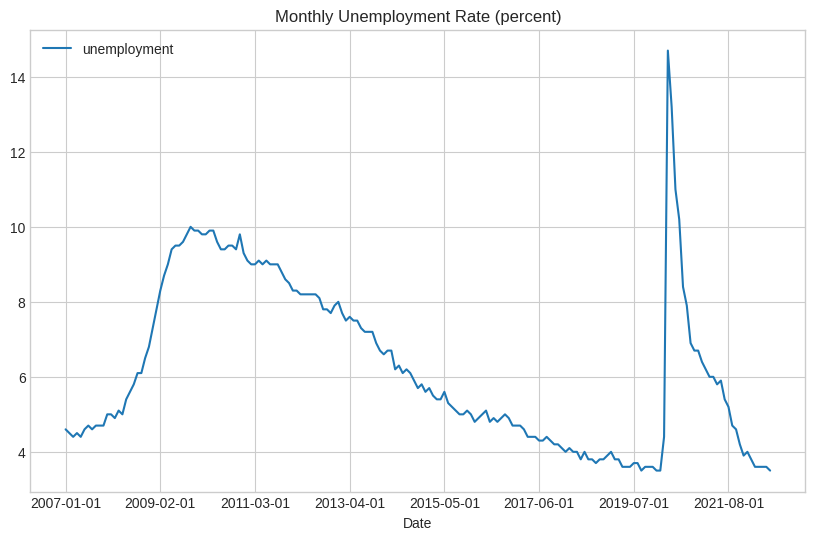

In [111]:

bls_unemployment_df.plot(grid=True, title='Monthly Unemployment Rate (percent)', figsize=(10, 6))


<h3>
Market Signals
</h3>
<p>
In this section we look at the S&P 500 yearly earnings momentum and employment momentum signals.
</p>
<p>
The signals are looked at individually and together. In the book, the portfolio is hedged when both signals are
"bearish".
</p>


In [112]:
def get_market_data(file_name: str,
                    data_col: str,
                    symbols: List,
                    data_source: str,
                    start_date: datetime,
                    end_date: datetime) -> pd.DataFrame:
    """
      file_name: the file name in the temp directory that will be used to store the data
      data_col: the type of data - 'Adj Close', 'Close', 'High', 'Low', 'Open', Volume'
      symbols: a list of symbols to fetch data for
      data_source: yahoo, etc...
      start_date: the start date for the time series
      end_date: the end data for the time series
      Returns: a Pandas DataFrame containing the data.

      If a file of market data does not already exist in the temporary directory, fetch it from the
      data_source.
    """
    temp_root: str = tempfile.gettempdir() + '/'
    file_path: str = temp_root + file_name
    temp_file_path = Path(file_path)
    file_size = 0
    if temp_file_path.exists():
        file_size = temp_file_path.stat().st_size

    if file_size > 0:
        close_data = pd.read_csv(file_path, index_col='Date')
    else:
        if type(symbols) == str:
            t = list()
            t.append(symbols)
            symbols = t
        panel_data: pd.DataFrame = data.DataReader(symbols, data_source, start_date, end_date)
        close_data: pd.DataFrame = panel_data[data_col]
        close_data.to_csv(file_path)
    assert len(close_data) > 0, f'Error reading data for {symbols}'
    return close_data


def bullish(data_df: pd.DataFrame, window: int) -> list:
    bullish_ix: List[int] = list()
    for i in range(window, data_df.shape[0]):
        if data_df.iloc[i].values[0] >= data_df.iloc[i - window].values[0]:
            bullish_ix.append(i)
    return bullish_ix


def bearish(data_df: pd.DataFrame, window: int) -> list:
    bearish_ix: List[int] = list()
    for i in range(window, data_df.shape[0]):
        if data_df.iloc[i].values[0] < data_df.iloc[i - window].values[0]:
            bearish_ix.append(i)
    return bearish_ix


def signal_dates(func: Callable, data_df: pd.DataFrame, window: int) -> DatetimeIndex:
    ix_l: List[int] = func(data_df, window)
    index = data_df.index
    dates = index[ix_l]
    return dates


def plot_hedge(instrument_df: pd.DataFrame, hedge_df: pd.DataFrame, title: str) -> None:
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    fig.autofmt_xdate()
    ax.plot(instrument_df, label=str(instrument_df.columns[0]))
    ax.plot(hedge_df, 'x', label=str(hedge_df.columns[0]))
    plt.title(title)
    ax.grid(visible=True)
    leg = ax.legend()
    plt.xlabel('Date')
    plt.ylabel('Close Price')


def get_market_indexes(market_df: pd.DataFrame, index_dates: DatetimeIndex) -> List[int]:
    ix_l: List = list()
    market_index = market_df.index
    for date_ in index_dates:
        ix = findDateIndex(date_index=market_index, search_date=date_)
        if ix >= 0:
            ix_l.append(ix)
        else:
            print(f'Did not find date {date_}')
    return ix_l

eps_bullish_dates = signal_dates(bullish, eps_yearly, window=3)
emp_bullish_dates = signal_dates(bullish, bls_unemployment_df, window=3)

eps_bearish_dates: pd.DatetimeIndex = signal_dates(bearish, eps_yearly, window=3)
emp_bearish_dates: pd.DatetimeIndex = signal_dates(bearish, bls_unemployment_df, window=3)

spy_data_file = 'spy_adj_close.csv'
spy_close_df = get_market_data(file_name=spy_data_file,
                               data_col='Adj Close',
                               symbols=['spy'],
                               data_source='yahoo',
                               start_date=start_date,
                               end_date=end_date)


<h4>
Yearly S&P Earnings Per Share Momentum Signal
</h4>
<p>
When the current S&P 500 estimate is below the previous three month estimate, the signal is considered bearish.
</p>
<p>
The plot below shows the S&P 500 (SPY ETF) in blue. The red 'x' points in the graph are the months where this signal
is "bearish".
</p>

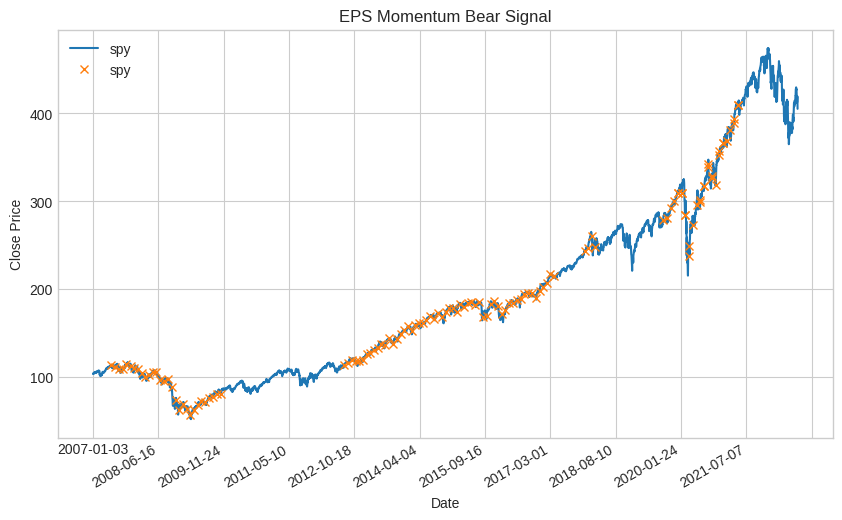

In [113]:
eps_ix_l = get_market_indexes(spy_close_df, eps_bearish_dates)
spy_eps_bear_df = spy_close_df.iloc[eps_ix_l]
plot_hedge(spy_close_df, spy_eps_bear_df, 'EPS Momentum Bear Signal')


<p>
The yearly S&P EPS indicator is bearish during the 2008 market crash. The signal is bearish in the recovery (2007 to
2010). Even worse, the signal is "bearish" during a significant market rise from late 2012 to early 2017. If this signal
were used alone to define the hedge period, there could be signifant losses in the S&P 500 short position.
</p>
<h4>
Monthly Employment Bearish Signal
</h4>
<p>
When the current monthly unemployment is below the previous three month employment value, the signal is considered bearish.
</p>

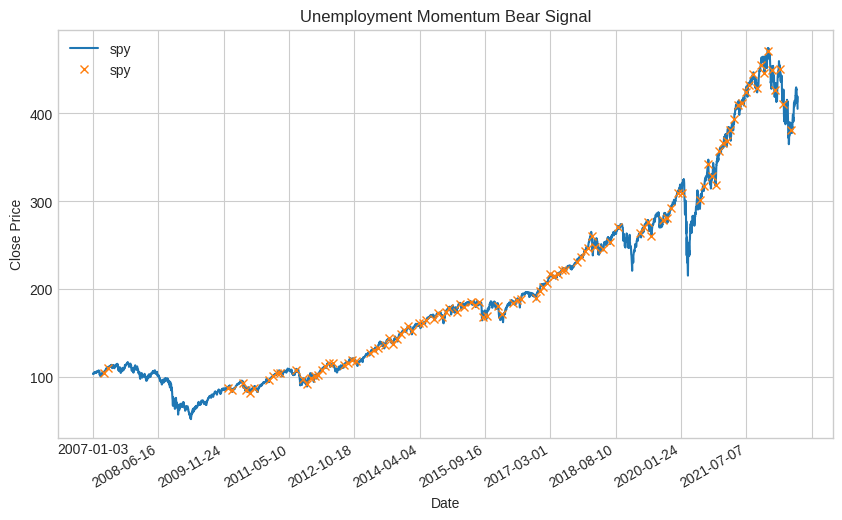

In [114]:
emp_ix_l = get_market_indexes(spy_close_df, emp_bearish_dates)
spy_emp_bear_df = spy_close_df.iloc[emp_ix_l]
plot_hedge(spy_close_df, spy_emp_bear_df, "Unemployment Momentum Bear Signal")


<h4>
Yearly S&P 500 EPS and Unemployment Bear Signal
</h4>
<p>
In the book Fred Paird writes that when both of the market timing signals are "bearish", the portfolio is hedged with a
short position in the S&P 500.
</p>
<p>
The plot below shows the months where both market timing signals are "bearish".
</p>

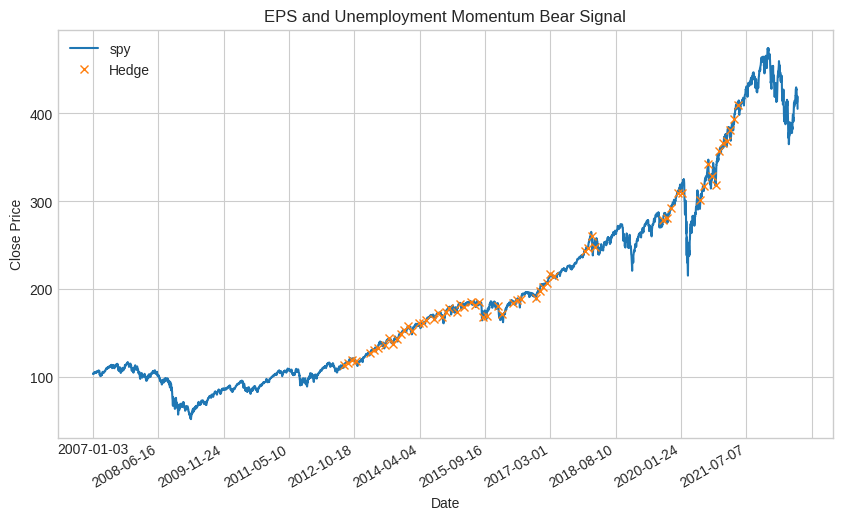

In [115]:
if len(eps_bearish_dates) >= len(emp_bearish_dates):
    bearish_dates_ = emp_bearish_dates.isin(eps_bearish_dates)
    bearish_dates = emp_bearish_dates[bearish_dates_]
else:
    bearish_dates_ = eps_bearish_dates.isin(emp_bearish_dates)
    bearish_dates = eps_bearish_dates[bearish_dates_]


ix_l = get_market_indexes(spy_close_df, bearish_dates)
spy_bear_df: pd.DataFrame = spy_close_df.iloc[ix_l]
spy_bear_df.columns = ['Hedge']

plot_hedge(spy_close_df, spy_bear_df, 'EPS and Unemployment Momentum Bear Signal')

<p>
The plot above shows that the market signals are "bearish" in periods of significant market
growth. Hedging with an S&P 500 short position could have significant losses, since the
market went up, although the signal was "bearish".
</p>
<h3>
Conclusion
</h3>
<p>
An investor would be ill-advised to follow the investment approach advocated by Fred Piard in <i>The Lazy Fundamental Analyst</i>.
Fundamental investment funds, that follow an approach similar to that outlined in the book, have done very poorly for at least ten
years.
</p>
<p>
For each sector the author selects a set of fundamental factors that he believes apply to that sector. A set of stocks from
the sector are selected as an example.
</p>
The author does not provide any
information on how the fundamental factors were selected, other than stating that there was quantitative backtesting
used to select these factors. Even if these factors were effective predictors for portfolio returns, the market is ever
changing and these factors may not be effective in the future.
</p>
<p>
The portfolio hedging recommended by the author is even more problematic than the fundamental factors. The results in this
notebook suggest that an investor would have significant losses following the hedging the author outlines.
</p>
<p>
If the market signals had looked promising, I would have built a portfolio from a sector ETF (e.g, XLE for the energy sector) and
combined this with a short position in the S&P 500 short ETF SH. This exercise does not seem to be worth the investment in time.
The plots above suggest that there would be significant losses in the portfolio since it is hedged during market growth.
</p>